### Load Model Samples
save dice:
dice is based on SSN Ens Mean I think? or SSN Ens? I am not sure....?
sample diversity definately comes from SSN Ens.
I am not sure how much memory I need for this aha
Sample diversity should be based on AVD and I should check the mean dice against what I have reported in my paper (it should be similar, probs won't be exactly the same).

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.run.model_load.load_ssn import load_ssn
from trustworthai.run.model_load.load_punet import load_p_unet
from trustworthai.run.model_load.load_deterministic import load_deterministic
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

print("banana")

strawberry
banana


In [2]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever

In [3]:
models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"

In [4]:
def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    # folder arguments
    parser.add_argument('--ckpt_dir', default='s2208943/results/revamped_models/', type=str)
    parser.add_argument('--model_name', default=None, type=str)
    
    # data generation arguments
    parser.add_argument('--dataset', default='ed', type=str)
    parser.add_argument('--seed', default=3407, type=int)
    parser.add_argument('--test_split', default=0.15, type=float)
    parser.add_argument('--val_split', default=0.15, type=float)
    parser.add_argument('--empty_slice_retention', default=0.1, type=float)
    
    # model specific parameters SSN
    parser.add_argument('--ssn_rank', default=15, type=int)
    parser.add_argument('--ssn_epsilon', default=1e-5, type=float)
    parser.add_argument('--ssn_mc_samples', default=10, type=int)
    parser.add_argument('--ssn_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--ssn_pre_head_layers', default=16, type=int)
    
    # evidential loss parameters
    parser.add_argument('--kl_factor', default=0.1, type=float)
    parser.add_argument('--kl_anneal_count', default=452*4, type=int)
    
     # model specific parameters Punet
    parser.add_argument('--kl_beta', default=10.0, type=float)
    parser.add_argument('--use_prior_for_dice', default=False, type=bool)
    parser.add_argument('--punet_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--latent_dim', default=12, type=int)
    
    # general arguments for the loss function
    parser.add_argument('--dice_factor', default=5, type=float)
    parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    
    # general arguments for the loss function
    parser.add_argument('--loss_name', default='dice+xent', type=str)
    # parser.add_argument('--dice_factor', default=5, type=float)
    # parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--xent_weight', default='none', type=str)
    #parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    parser.add_argument('--tversky_beta', default=0.7, type=float)
    parser.add_argument('--reduction', default='mean_sum', type=str)
    
    # training paradigm arguments
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--dropout_p', default=0.0, type=float)
    parser.add_argument('--max_epochs', default=100, type=int)
    parser.add_argument('--early_stop_patience', default=15, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--cross_validate', default=False, type=bool)
    parser.add_argument('--cv_split', default=0, type=int)
    parser.add_argument('--cv_test_fold_smooth', default=1, type=int)
    parser.add_argument('--weight_decay', default=0.0001, type=float)
    parser.add_argument('--overwrite', default=False, type=bool)
    
    return parser

In [5]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [6]:
def entropy_map_from_mean(mean, do_normalize=True):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if mean.shape[1] == 1:
        raise ValueError("not implemented for implicit background class")
    else:
        assert mean.shape[1] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(mean, dim=1)
    else:
        probs = mean
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)

    return ent_map

In [7]:
def generate_means_and_samples_SSN(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    rank = 15
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":rank,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_WMH_chal"
    ensemble_element = 1

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.15,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(1):
            model_name = model_base_name + f"_ens{ensemble_element}/"
            model_path = models_folder + model_name

            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()


            dataskip = dataset_stride
            
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples, temperature=temp)
                    means.append(mean.cpu())
                    samples.append(sample.cpu())

    return means, samples, ConcatDataset(test_datasets)

In [9]:
def generate_means_and_samples_SSN_Ens_Efficient(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False, ensemble_size=6):
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_WMH_chal"

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        model_outs = defaultdict(lambda : {'means':[], 'samples':[]})
        
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.15,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(ensemble_size):
            model_name = model_base_name + f"_ens{ens}/"
            model_path = models_folder + model_name

            # with open(model_path + "best_ckpt.txt") as f:
            #     lines = f.readlines()
            #     args_lines = [l[:-1].split(": ") for l in lines[1:]]
            #     args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            #     args_line = " ".join(args_lines)
            #     parser = construct_parser()
            #     args = parser.parse_args(shlex.split(args_line))

            # load the model
            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()


            dataskip = dataset_stride
            # means = []
            # samples = []
            for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
                if i % dataskip == 0:
                    x = data[0]
                    with torch.no_grad():
                        mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples, temperature=temp, symmetric=False)

                        model_outs[i]['means'].append(mean.cpu())
                        model_outs[i]['samples'].append(sample.cpu())

        for idx in tqdm(model_outs.keys(), position=0, leave=True):
            means.append(torch.stack(model_outs[idx]['means'], dim=0).mean(dim=0))
            samples.append(torch.cat(model_outs[idx]['samples'], dim=0))

    return means, samples, ConcatDataset(test_datasets)

In [10]:
def generate_means_and_samples_SSN_Ens_Mean(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False, ensemble_size=6):
    components = ensemble_size
    # load data
    print("loading")
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    print("loaded")
    
    test_datasets = []

    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    model_raw.return_cpu_dist = True

    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_WMH_chal"

    means = []
    samples = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        # print("size: ", len(test_ds_clin))

        dataskip = dataset_stride

        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0].swapaxes(0,1).cuda()
                distribution_means = []
                distribution_cov_diags = []
                distribution_cov_factors = []
                distribution_event_shapes = []

                for ens in range(components):
                    # print(ens)
                    model_name = model_base_name + f"_ens{ens}/"
                    model_path = models_folder + model_name
                    model = load_best_checkpoint(model_raw, loss, model_path)
                    model.eval()

                    with torch.no_grad():
                        mean, cov_diag, cov_factor, event_shape = model(x)
                    distribution_means.append(mean.cpu())
                    distribution_cov_diags.append(cov_diag.cpu())
                    distribution_cov_factors.append(cov_factor.cpu())
                    distribution_event_shapes.append(event_shape)

                # print(distribution_means[0].shape)

                distribution_means = torch.stack(distribution_means, dim=0).mean(dim=0)
                distribution_cov_diags = torch.stack(distribution_cov_diags, dim=0).mean(dim=0)
                distribution_cov_factors = torch.stack(distribution_cov_factors, dim=0).mean(dim=0)

                # print(distribution_means.shape)

                dist = LowRankMultivariateNormalCustom(distribution_means, distribution_cov_factors, distribution_cov_diags)
                dist = ReshapedDistribution(dist, distribution_event_shapes[0])

                means.append((dist.mean / temp).cpu())
                samples.append((model_raw._samples_from_dist(dist, num_samples=num_samples)/temp).cpu())

    return means, samples, ConcatDataset(test_datasets)

In [11]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write
import pandas as pd

In [12]:
#samples[0].shape

In [13]:
stride = 1

In [14]:
# means, samples, test_datasets = generate_means_and_samples_SSN(splits=6, dataset_stride=stride, temp=1, num_samples=10)
means, samples, test_datasets = generate_means_and_samples_SSN_Ens_Efficient(splits=6, dataset_stride=stride, temp=1, num_samples=2, use_updated_scores=False)
# means, samples, test_datasets = generate_means_and_samples_SSN_Ens_Mean(splits=6, dataset_stride=stride, temp=1, num_samples=10, use_updated_scores=False)

size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 18.44it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.42it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 11.04it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.78it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.59it/s]


size:  40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.96it/s]


In [15]:
len(means), len(samples)

(250, 250)

In [16]:
# softmax entropy
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

# evidential
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

# other methods
ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]

(-0.5, 159.5, 223.5, -0.5)

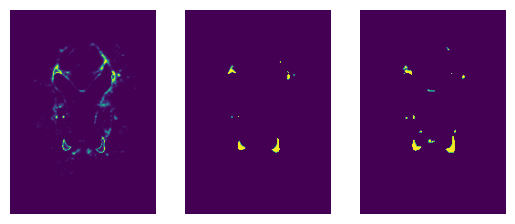

In [17]:
scan_id = 0
islice = 20
plt.subplot(1,3,1)
plt.imshow(ent_maps[scan_id][islice]); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(means[scan_id][islice].argmax(dim=0)); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test_datasets[scan_id][1][0][islice]); plt.axis('off')

In [18]:
def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return (numerator/(denominator + 1e-30)).item()

In [19]:
means[0].shape

torch.Size([40, 2, 224, 160])

In [20]:
dices = []
for i in tqdm(range(len(means)), position=0, leave=True):
    pred = means[i].cuda().argmax(dim=1)
    target = test_datasets[i][1][0].cuda()
    dices.append(fast_dice(pred, target))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 81.36it/s]


In [21]:
f_dices = [d for d in dices if d > 0.01]

In [22]:
torch.Tensor(f_dices).mean()

tensor(0.5605)

In [23]:
IDs = [data[2]['ID'] for data in test_datasets]

In [24]:
# now compute all the metrics for the mean prediction, dice, avd, lesion f1 score.

import SimpleITK as sitk
import numpy as np
import torch
from tqdm import tqdm
import scipy

def getDSC(testImage, resultImage):    
        """Compute the Dice Similarity Coefficient."""
        # testArray   = sitk.GetArrayFromImage(testImage).flatten()
        # resultArray = sitk.GetArrayFromImage(resultImage).flatten()
        testArray = testImage.reshape(-1).cpu().numpy()
        resultArray = resultImage.reshape(-1).cpu().numpy()

        # similarity = 1.0 - dissimilarity
        return 1.0 - scipy.spatial.distance.dice(testArray, resultArray) 

def getLesionDetection(testImage, resultImage):    
    """Lesion detection metrics, both recall and F1."""
    testImage = sitk.GetImageFromArray(testImage)
    resultImage = sitk.GetImageFromArray(resultImage)

    # Connected components will give the background label 0, so subtract 1 from all results
    ccFilter = sitk.ConnectedComponentImageFilter()    
    ccFilter.SetFullyConnected(True)

    # Connected components on the test image, to determine the number of true WMH.
    # And to get the overlap between detected voxels and true WMH
    ccTest = ccFilter.Execute(testImage)    
    lResult = sitk.Multiply(ccTest, sitk.Cast(resultImage, sitk.sitkUInt32))

    ccTestArray = sitk.GetArrayFromImage(ccTest)
    lResultArray = sitk.GetArrayFromImage(lResult)

    # recall = (number of detected WMH) / (number of true WMH) 
    nWMH = len(np.unique(ccTestArray)) - 1
    if nWMH == 0:
        recall = 1.0
    else:
        recall = float(len(np.unique(lResultArray)) - 1) / nWMH

    # Connected components of results, to determine number of detected lesions
    ccResult = ccFilter.Execute(resultImage)
    lTest = sitk.Multiply(ccResult, sitk.Cast(testImage, sitk.sitkUInt32))

    ccResultArray = sitk.GetArrayFromImage(ccResult)
    lTestArray = sitk.GetArrayFromImage(lTest)

    # precision = (number of detections that intersect with WMH) / (number of all detections)
    nDetections = len(np.unique(ccResultArray)) - 1
    if nDetections == 0:
        precision = 1.0
    else:
        precision = float(len(np.unique(lTestArray)) - 1) / nDetections

    if precision + recall == 0.0:
        f1 = 0.0
    else:
        f1 = 2.0 * (precision * recall) / (precision + recall)

    return recall, f1    


def getAVD(testImage, resultImage):   
    """Volume statistics."""
    testImage = sitk.GetImageFromArray(testImage)
    resultImage = sitk.GetImageFromArray(resultImage)

    # Compute statistics of both images
    testStatistics   = sitk.StatisticsImageFilter()
    resultStatistics = sitk.StatisticsImageFilter()

    testStatistics.Execute(testImage)
    resultStatistics.Execute(resultImage)

    return float(abs(testStatistics.GetSum() - resultStatistics.GetSum())) / float(testStatistics.GetSum()) * 100

In [25]:
dices = []
avds = []
f1s = []
recalls = []
for i in tqdm(range(len(means)), position=0, leave=True):
    pred = means[i].argmax(dim=1)
    target = test_datasets[i][1][0].type(torch.int64)
    dices.append(getDSC(target, pred))
    avds.append(getAVD(target.numpy(), pred.numpy()))
    recall, f1 = getLesionDetection(target.numpy(), pred.numpy())
    recalls.append(recall)
    f1s.append(f1)
    # break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:02<00:00,  2.05it/s]


In [26]:
### recording the sample diversity of volumes. (I can get range, IQR, coefficient of variation, skewness)
results = []
for i, s in tqdm(enumerate(samples), position=0, leave=True, total=len(samples)):
    s_pred = s.cuda().argmax(dim=2)
    slices = s.shape[1]
    num_samples = s.shape[0]
    s_pred = s.argmax(dim=2)
    slice_vols = s_pred.sum(dim=(-2, -1))
    sorted_slice_vols = torch.sort(slice_vols, dim=0)[1]
    sorted_samples = torch.zeros(s_pred.shape)
    for j in range(num_samples):
        sorted_samples[j] = s_pred[sorted_slice_vols[j], torch.arange(0, slices, 1)]
    sorted_sample_volumes = sorted_samples.sum(dim=(-3, -2, -1)).cpu()
    
    assert torch.equal(sorted_sample_volumes, torch.sort(sorted_sample_volumes)[0])
    
    mean_vol = means[i].cuda().argmax(dim=1).sum(dim=(-3, -2, -1)).item()
    
    ss_vds = ((sorted_sample_volumes - mean_vol).abs() / mean_vol) * 100
    
    results.append([
        sorted_sample_volumes.std().item(),
        scipy.stats.iqr(sorted_sample_volumes),
        scipy.stats.skew(sorted_sample_volumes),
        
        ss_vds.std().item(),
        scipy.stats.iqr(ss_vds),
        scipy.stats.skew(ss_vds),
        
    ])
    

  8%|████████████▊                                                                                                                                           | 21/250 [00:56<10:38,  2.79s/it]/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [12:10<00:00,  2.92s/it]


In [27]:
import pandas as pd
df = {
    "ID":IDs,
    "dice":dices,
    "f1":f1s,
    "avd":avds,
    "recall":recall,
    "sample_div_std":[r[0] for r in results],
    "sample_div_IQR":[r[1] for r in results],
    "sample_div_skew":[r[2] for r in results],
    "sample_div_vd_std":[r[3] for r in results],
    "sample_div_vd_IQR":[r[4] for r in results],
    "sample_div_vd_skew":[r[5] for r in results],
}

df = pd.DataFrame(df)
df.to_csv("umap_data_spreadsheets/CVD/CHAL_BASED_sample_div_data_SSN_Ens.csv")